In [1]:
import logging
import os
import sys
import re

import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List, Callable, NoReturn, NewType, Any
import dataclasses
from datasets import load_metric, load_from_disk, Dataset, DatasetDict

from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer
from transformers import (
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    TrainingArguments,
    set_seed,
)

In [3]:
sys.path.append('../')

In [4]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece

from utils_qa import postprocess_qa_predictions, check_no_error
from trainer_qa import QuestionAnsweringTrainer
from retrieval import SparseRetrieval

from arguments import (
    ModelArguments,
    DataTrainingArguments,
)

## Raw Data

In [5]:
datasets = load_from_disk('/opt/ml/data/train_dataset')

In [6]:
datasets

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 240
    })
})

In [7]:
train_data = datasets['train']
train_size = len(train_data)

## Check Length

In [8]:
q_len = []
c_len = []

for data in train_data :
    question = data['question']
    context = data['context'] 
    q_len.append(len(question))
    c_len.append(len(context))

## Tokenizer

In [10]:
model_args = ModelArguments

config = AutoConfig.from_pretrained(
    model_args.config_name 
    if model_args.config_name is not None
    else model_args.model_name_or_path,
)

# -- Tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_args.tokenizer_name
    if model_args.tokenizer_name is not None
    else model_args.model_name_or_path,
    # 'use_fast' argument를 True로 설정할 경우 rust로 구현된 tokenizer를 사용할 수 있습니다.
    # False로 설정할 경우 python으로 구현된 tokenizer를 사용할 수 있으며,
    # rust version이 비교적 속도가 빠릅니다.
    use_fast=True,
)
 

In [11]:
tokenizer

PreTrainedTokenizerFast(name_or_path='klue/roberta-large', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [12]:
q_tok_len = []
c_tok_len = []

for data in train_data :
    question = tokenizer.tokenize(data['question'])
    context = tokenizer.tokenize(data['context'])
    q_tok_len.append(len(question))
    c_tok_len.append(len(context))

Token indices sequence length is longer than the specified maximum sequence length for this model (1020 > 512). Running this sequence through the model will result in indexing errors


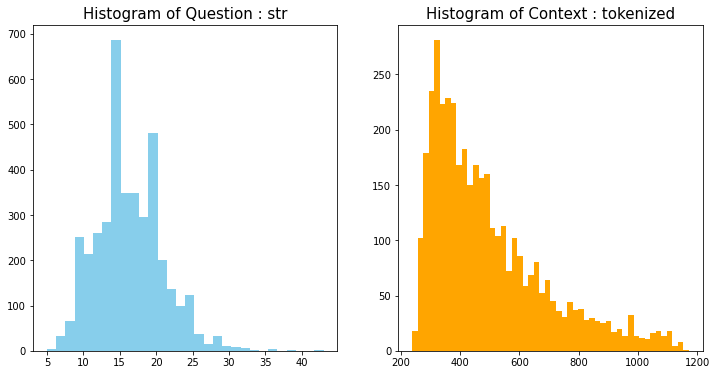

In [18]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].set_title('Histogram of Question : str', fontsize = 15)
axes[0].hist(q_tok_len, bins=30, color='skyblue')

axes[1].set_title('Histogram of Context : tokenized' , fontsize = 15)
axes[1].hist(c_tok_len, bins=50, color='orange')

plt.show()

## Highlit

In [14]:
from IPython.core.display import HTML

def word_highligt_html(txt, word, color, highlight=None):
    txt = txt.replace(word, f'<span style="color: {color}; background-color:{highlight}">{word}</span>')
    return txt

In [15]:
questions = []
for data in train_data :
    questions.append(data['question'])

In [16]:
unk_id = tokenizer.convert_tokens_to_ids('[UNK]')

In [17]:
unk_ans_count = 0

for q in questions : 
    ids = tokenizer.encode(q)
    if unk_id in ids : 
        unk_ans_count += 1

In [19]:
print('Size of questions which has unk token : %d' %unk_ans_count)

Size of questions which has unk token : 64


In [20]:
q_highlited = ''

for i in tqdm(range(train_size)) :
    q = questions[i]
    
    flag = False
    for ch in q :
        if ch == ' ' :
            continue
        ids = tokenizer.convert_tokens_to_ids(ch)
        if ids == unk_id :
            q = word_highligt_html(q, ch, 'black', '#B19CD9')
            flag = True
    
    if flag == True :
        q_highlited += str(i) + ' - ' + q + '<br/>'

100%|██████████| 3952/3952 [00:00<00:00, 42198.67it/s]


In [21]:
HTML(q_highlited)

In [22]:
ans_span = []
ans_pos = []

for data in train_data :
    pos, span = data['answers']['answer_start'], data['answers']['text']
    ans_span.append(span[0])
    ans_pos.append(pos[0])

In [23]:
ans_tok_len = [len(tokenizer.tokenize(ans)) for ans in ans_span]

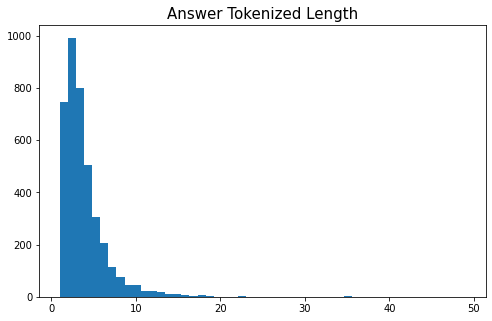

In [25]:
plt.figure(figsize=(8,5))
plt.title('Answer Tokenized Length', fontsize = 15)
plt.hist(ans_tok_len, bins=50)
plt.show()

In [24]:
unk_ans_count = 0

for span in ans_span : 
    ids = tokenizer.encode(span)
    if unk_id in ids : 
        unk_ans_count += 1

print('Size of answers which has unk token : %d' %unk_ans_count)

Size of answers which has unk token : 68


In [26]:
ans_highlited = ''

for i in tqdm(range(train_size)) :
    span = ans_span[i]
    
    flag = False
    for ch in span :
        if ch == ' ' :
            continue
        ids = tokenizer.convert_tokens_to_ids(ch)
        if ids == unk_id :
            span = word_highligt_html(span, ch, 'black', '#96C4ED')
            flag = True
    
    if flag == True :
        ans_highlited += str(i) + ' - ' + span + '<br/>'

100%|██████████| 3952/3952 [00:00<00:00, 149754.62it/s]


In [27]:
HTML(ans_highlited)

## Context & Length

In [28]:
contexts = []

for data in train_data :
    con = data['context']
    contexts.append(con)

In [29]:
def span_highligt_html(txt, start, end, color):
    txt = txt[:start] + f'<span style="color: {color}">{txt[start:end]}</span>' + txt[end:] 
    return txt

In [30]:
def word_highligt_html(txt, word, highlight):
    txt = txt.replace(word, f'<span style="background-color:{highlight}">{word}</span>')
    return txt

In [31]:
def context_highligt_html(context, ans_word, ans_pos, color, highlit) :
    start = ans_pos
    end = ans_pos + len(ans_word)
    
    context = span_highligt_html(context, start, end, color)
    context = word_highligt_html(context, ans_word, highlit)
    
    return context

In [32]:
test1 = context_highligt_html(contexts[0], ans_span[0], ans_pos[0], 'white' , '#96C4ED')

In [33]:
HTML(test1)

In [34]:
test2 = context_highligt_html(contexts[350], ans_span[350], ans_pos[350], 'white' , '#96C4ED')

In [35]:
HTML(test2)

In [36]:
multi_count = 0

for i in range(train_size) :
    con = contexts[i]
    span = ans_span[i]
    span_list = re.findall(span, con)
    
    if len(span_list) > 1 :
        multi_count += 1
    

In [37]:
print('Size of answer if appeared multiple times in context : %d' %multi_count)

Size of answer if appeared multiple times in context : 1310


## Context UNK Token

In [38]:
print('Original Text \n')
print(contexts[0])

Original Text 

미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\n\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\n\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05


In [39]:
from nltk.tokenize import word_tokenize

In [40]:
unk_tokens = []

for i, con in enumerate(tqdm(contexts)) : 
    con = re.sub(r'\\n' , '', con)
    word_list = word_tokenize(con)

    for word in word_list :
        ids_list = tokenizer.encode(word)
        if unk_id in ids_list :
            unk_tokens.append((i,word))

100%|██████████| 3952/3952 [01:07<00:00, 58.70it/s]


In [43]:
print('Size of word which make unk token : %d' %len(unk_tokens))

Size of word which make unk token : 3972


In [44]:
for i in range(20,40) :
    print(unk_tokens[i])

(13, '李淳鎔')
(15, '草日記')
(16, '베르됭에서')
(16, '베르됭')
(16, '베르됭은')
(16, '베르됭에서의')
(17, '깰')
(18, '梅田')
(20, '쪼갰고')
(20, '恒山')
(24, '羽化')
(24, '過變態')
(24, '前胸腺')
(24, '相同器官')
(24, '幼期')
(24, '若蟲')
(26, 'Πάτρα')
(26, 'Πάτραι')
(30, '素髮')
(30, '優塡王')


### Korean

In [45]:
kor_start_idx = int('AC00', 16)
kor_end_idx = int('D7A3', 16)

In [46]:
kor_chars = []
for i in range(kor_start_idx , kor_end_idx + 1) :
    kor_chars.append(chr(i))

### Japanese

In [47]:
jp_start_idx = int('3040', 16)
jp_end_idx = int('30FF', 16)

In [48]:
jp_chars = []
for i in range(jp_start_idx , jp_end_idx + 1) :
    jp_chars.append(chr(i))

### Chinese

In [49]:
ch_start_idx = int('4E00', 16)
ch_end_idx = int('9FFF', 16)

In [50]:
ch_chars = []
for i in range(ch_start_idx , ch_end_idx + 1) :
    ch_chars.append(chr(i))

In [51]:
def check_jp(word) :
    for ch in word :
        if ch not in jp_chars :
            return False
    return True

def check_kr(word) :
    for ch in word :
        if ch not in kor_chars :
            return False
    return True

def check_ch(word) :
    for ch in word :
        if ch not in ch_chars :
            return False
    return True


In [52]:
def check_unk(word) :
    if check_jp(word) :
        return 'jp'
    elif check_kr(word) :
        return 'kr'
    elif check_ch(word) :
        return 'ch'
    else :
        return 'unknown'

In [61]:
unk_kinds = [check_unk(unk[1]) for unk in unk_tokens]

In [62]:
import collections
counter = collections.Counter()

In [63]:
counter.update(unk_kinds)

In [64]:
counter = dict(counter)

In [65]:
counter

{'ch': 2090, 'kr': 1313, 'unknown': 548, 'jp': 21}

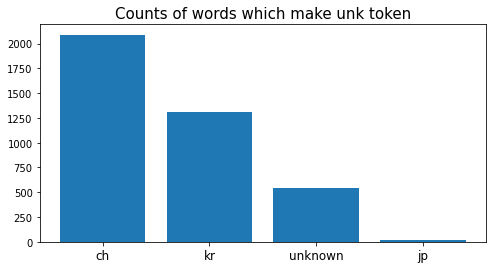

In [66]:
plt.figure(figsize = (8,4))

x_list = list(counter.keys())
y_list = list(counter.values())

plt.title('Counts of words which make unk token', fontsize = 15)
plt.bar(x_list, y_list)
plt.xticks(fontsize = 12)

plt.show()

## Preprocessing

  1. 개행문자 제거
  2. 한국어 -> [UNK]를 불러일으키는 문자 띄어쓰기
  3. 중국어 -> [UNK]아닌 [CHN] Special Token으로 변환
  4. 한국어 -> [UNK]아닌 [KOR] Special Toke으로 변환
  5. 나머지 -> [UNK]로 변환


In [67]:
from konlpy.tag import Mecab
mecab = Mecab()

#### 개행문자 제거

In [68]:
test_con = contexts[0]
test_q = questions[0]

print('Orgiginal Question')
print(test_q)
print('\n')
print('Orginal Context')
print(test_con)

Orgiginal Question
대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?


Orginal Context
미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\n\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\n\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05


In [69]:
 def remove_newline(txt) :
    txt = re.sub(r'\\n' , '', txt)
    return txt

print(remove_newline(test_con))

미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05


### 한국어 띄어쓰기

In [70]:
def space_nouns(context) :
    noun_list = mecab.nouns(context)
    def add_space(match) :
        bracket = match.group()
        added = ' ' + bracket
        return added
    
    re_comp = re.compile('|'.join(noun_list))
    context = re_comp.sub(add_space, context)
    context = re.sub('\s+', ' ', context)
    return context.strip()

print(space_nouns(remove_newline(test_con)))

미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다. 미국 부통령이 상원 의장이 된다. 각 주당 2 명의 상원 의원이 선출되어 100 명의 상원 의원으로 구성되어 있다. 임기는 6 년이며, 2 년마다 50 개주 중 1/3씩 상원 의원을 새로 선출하여 연방에 보낸다. 미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할( 하원의 법안을 거부할 권한 등)을 담당한다. 2 년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강 보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션( 공공 건강 보험 기관)의 조항이 있는 반면 상원의 경우 하원 안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비 영리 건강 보험 기관이나 보험 회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각 책임 제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비 정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리 사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다. 날짜=2017-02-05


##### 비교

In [71]:
a = '미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다.'

In [72]:
b = space_nouns(a)

In [73]:
tok_a_list = tokenizer.tokenize(a)
tok_b_list = tokenizer.tokenize(b)

for i in range(40) :
    print('%s \t %s' %(tok_a_list[i], tok_b_list[i]))

미국 	 미국
연방 	 연방
행정부 	 행정부
##에 	 ##에
##게 	 ##게
퍼블 	 퍼블
##릭 	 ##릭
옵션 	 옵션
( 	 (
공공 	 공공
##건 	 건강
##강 	 보험
##보험 	 기관
##기 	 )
##관 	 의
) 	 조항
의 	 ##이
조항 	 있
##이 	 ##는
있 	 반면
##는 	 상원
반면 	 ##의
상원 	 경우
##의 	 하원
경우 	 안이
하원 	 지나치
##안 	 ##게
##이 	 세금
지나치 	 ##이
##게 	 많이
세금 	 든다는
##이 	 이유로
많이 	 퍼블
든다는 	 ##릭
이유로 	 옵션
퍼블 	 조항
##릭 	 ##을
옵션 	 제외
조항 	 ##하고
##을 	 비


#### Check Chinese Special Token

In [74]:
ch_start_idx = int('4E00', 16)
ch_end_idx = int('9FFF', 16)

In [75]:
ch_chars = []
for i in range(ch_start_idx , ch_end_idx + 1) :
    ch_chars.append(chr(i))

In [77]:
ch_sub = re.compile('[' + ''.join(ch_chars) + ']')

In [120]:
def convert_ch(txt) :
    txt = ch_sub.sub('[CHN]' , txt)
    txt = re.sub(r'(\[CHN\]){1,}', '[CHN]', txt)
    return txt

In [123]:
contexts[24]

'대부분의 곤충은 알에서 태어난다. 몇몇 종은 어미의 몸 속에서 깨어나 일정기간 자란 후 나오는 난태생을 하는 것도 있다. 곤충의 애벌래는 자라면서 껍질을 벗고 새로운 껍질이 생기는 탈피를 한다. 탈피를 한 번 할 때의 기간을 령이라고 하는데, 누에나방은 약 24일 동안 4번의 탈피를 하며 각각의 시기를 1령, 2령 하는 식으로 부른다. \\n\\n탈피(허물 벗기)는 모든 절지동물이 견뎌야 하는 복잡하고 시간이 걸리는 위험한 과정이다. 탈피는 곤충이 일정한 크기에 이르면 체벽에 잇는 감지기가 뇌에 신호를 보내면서 시작되는 것으로 알려져 있다. 허물 벗기는 묵은 큐티클을 새로 활성화한 표피에서 분리하고 새로운 큐티클을 만들어 단단하게 만든다. 곤충의 애벌레가 한번 탈피해서 다시 탈피할 때까지의 시기를 영으로 구분한다. 유충이 몇 번 탈피해서 성충이 되는가 하는 것은 종에 따라 다르다. 어떤 파리는 4번의 탈피로 끝내는가 하면, 딱정벌레의 유충은 번데기가 될 때까지 27번이나 탈피를 한다.\\n\\n애벌레는 성충이 되는 과정에서 형태가 변화는 변태를 한다. 변태는 애벌레의 모습이 남아있는 불완전 변태와 완전히 그 모습이 변하는 완전 변태로 나눈다. 유시아강에 속하는 곤충들 가운데 일부만이 완전변태를 한다. 불완전변태는 유충이 성충과 비슷한 점이 있고, 초기부터 날개와 외부생식기를 외부에서도 볼 수 있으며, 탈피할 때마다 커져 최후의 탈피에서 성충이 되는데 반하여, 완전변태는 유충이 성충과는 전혀 달라서 날개 등을 외부에서는 전혀 볼 수 없고, 휴지기인 번데기 시기에 최후의 탈피인 우화(羽化)를 함으로써 성충이 된다. 또 완전변태 중에서 유충기의 탈피 때마다 형태가 달라지는 기생벌 등이 있는데, 이런 경우를 과변태(過變態)라고 한다.\\n\\n변태와 탈피는 뇌의 분비세포에서 나온 호르몬이 전흉선(前胸腺) 또는 그 상동기관(相同器官)을 자극하여 에크디손(ecdyson)의 분비를 촉진시킴으로써 일어나는데, 그 때 알라타체(體)에서 나온 유충호르몬이 충분히 있어야 한다.

In [124]:
convert_ch(contexts[24])

'대부분의 곤충은 알에서 태어난다. 몇몇 종은 어미의 몸 속에서 깨어나 일정기간 자란 후 나오는 난태생을 하는 것도 있다. 곤충의 애벌래는 자라면서 껍질을 벗고 새로운 껍질이 생기는 탈피를 한다. 탈피를 한 번 할 때의 기간을 령이라고 하는데, 누에나방은 약 24일 동안 4번의 탈피를 하며 각각의 시기를 1령, 2령 하는 식으로 부른다. \\n\\n탈피(허물 벗기)는 모든 절지동물이 견뎌야 하는 복잡하고 시간이 걸리는 위험한 과정이다. 탈피는 곤충이 일정한 크기에 이르면 체벽에 잇는 감지기가 뇌에 신호를 보내면서 시작되는 것으로 알려져 있다. 허물 벗기는 묵은 큐티클을 새로 활성화한 표피에서 분리하고 새로운 큐티클을 만들어 단단하게 만든다. 곤충의 애벌레가 한번 탈피해서 다시 탈피할 때까지의 시기를 영으로 구분한다. 유충이 몇 번 탈피해서 성충이 되는가 하는 것은 종에 따라 다르다. 어떤 파리는 4번의 탈피로 끝내는가 하면, 딱정벌레의 유충은 번데기가 될 때까지 27번이나 탈피를 한다.\\n\\n애벌레는 성충이 되는 과정에서 형태가 변화는 변태를 한다. 변태는 애벌레의 모습이 남아있는 불완전 변태와 완전히 그 모습이 변하는 완전 변태로 나눈다. 유시아강에 속하는 곤충들 가운데 일부만이 완전변태를 한다. 불완전변태는 유충이 성충과 비슷한 점이 있고, 초기부터 날개와 외부생식기를 외부에서도 볼 수 있으며, 탈피할 때마다 커져 최후의 탈피에서 성충이 되는데 반하여, 완전변태는 유충이 성충과는 전혀 달라서 날개 등을 외부에서는 전혀 볼 수 없고, 휴지기인 번데기 시기에 최후의 탈피인 우화([CHN])를 함으로써 성충이 된다. 또 완전변태 중에서 유충기의 탈피 때마다 형태가 달라지는 기생벌 등이 있는데, 이런 경우를 과변태([CHN])라고 한다.\\n\\n변태와 탈피는 뇌의 분비세포에서 나온 호르몬이 전흉선([CHN]) 또는 그 상동기관([CHN])을 자극하여 에크디손(ecdyson)의 분비를 촉진시킴으로써 일어나는데, 그 때 알라타체([CHN])에서 나온 유충호르몬이

#### Check Korean Special Token

In [125]:
kor_start_idx = int('AC00', 16)
kor_end_idx = int('D7A3', 16)

In [126]:
kor_chars = []
for i in range(kor_start_idx , kor_end_idx + 1) :
    kor_chars.append(chr(i))

In [131]:
kor_unks = []

for ch in kor_chars : 
    if tokenizer.convert_tokens_to_ids(ch) == unk_id :
        kor_unks.append(ch)

print('Size of Korean UNK Characters : %d' %len(kor_unks))

Size of Korean UNK Characters : 9741


In [143]:
special_tokens_dict = {'additional_special_tokens': ['[KOR]','[CHN]']}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

In [135]:
kor_sub = re.compile('[' + ''.join(kor_unks) + ']')

In [136]:
def convert_kr(txt) :
    txt = kor_sub.sub('[KOR]' , txt)
    txt = re.sub(r'(\[KOR\]){1,}', '[KOR]', txt)
    return txt

In [154]:
a = '도스토옙스키는 젊었을 때 어떤 사상을 추구하는 정치 클럽에 참여하였나?'
b = convert_kr(a)

In [157]:
tok_a_list = tokenizer.tokenize(a)
tok_b_list = tokenizer.tokenize(b)

for i in range(10) :
    print('%s \t %s' %(tok_a_list[i], tok_b_list[i]))

[UNK] 	 도스토
젊 	 [KOR]
##었 	 스키
##을 	 ##는
때 	 젊
어떤 	 ##었
사상 	 ##을
##을 	 때
추구 	 어떤
##하 	 사상


In [158]:
a = '카를 체르니가 공연한 쾰른토나토아 극장은 어느 도시에 있는가?'
b = convert_kr(a)

In [160]:
tok_a_list = tokenizer.tokenize(a)
tok_b_list = tokenizer.tokenize(b)

for i in range(15) :
    print('%s \t %s' %(tok_a_list[i], tok_b_list[i]))

카를 	 카를
체 	 체
##르 	 ##르
##니 	 ##니
##가 	 ##가
공연 	 공연
##한 	 ##한
[UNK] 	 [KOR]
극장 	 른
##은 	 ##토
어느 	 ##나
도시 	 ##토
##에 	 ##아
있 	 극장
##는 	 ##은
